Celem ćwiczenia jest zaimplementowanie filtrowania ruchu w sieci z wykorzystaniem uczenia maszynowego. Zastosowane techniki oparte na publikacji naukowej [MAP4: A Pragmatic Framework for In-Network Machine Learning Traffic Classification](https://ieeexplore.ieee.org/document/9913715). <br><br>
Opis procesu:
- Przygotowanie zbioru danych z pakietami sieciowymi zaklasyfikowanymi jako ruch niezłośliwy lub złośliwy.
- Wytrenowanie drzewa decyzyjnego do wykrywania anomali
- Przerobienie drzewa na format akceptowany przez P4
- Przypisanie pakeitom klasy w switchu dzieki drzewu decyzyjnemu
- Filtrowanie pakietów na podstawie klasy

In [130]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix

# 1. Przygotowanie Danych 

Do nauki drzewa urzyjemy danych ze zbioru [CIC-IDS2017](https://www.unb.ca/cic/datasets/ids-2017.html). Jest to zbiór ruchu sieciowego obejmujący ruch normalany jak i różne rodzaje ataków m.in. DoS Hulk, Web Attack – Brute Force czy FTP-Patator. Dane zostały zebrane przez 5 dni, obejmując aktywność 25 realistycznych użytkowników oraz różnorodne protokoły sieciowe.
Oprócz plików pcap z surowym ruchem sieciowym zawiera on również pliki csv. W plikach tych ruch sieciowy zagregowany jest do przepływów - ogółu pakietów w sieci posiadajacych te same wartości w 5 polach: Adres źródłowy IP, Port Źródłowy, Adres Docelowy IP, Port Docelowy oraz Protokół. Każdy z przepływów ma przyporządkowaną klase wskazującą czy jest to ruch normlany czy dany atak. <br><br>
Jako że switch będzie przetwarzał pojedyncze pakiety, potrzebujemy zbiór danych, który do danego pakietu przypisze klase. Zbiór w tej postaci można znaleźć [tutaj](https://github.com/rdpahalavan/nids-datasets) w postaci bilbioteki do Pythona. Zbiór ten posiada 260 kolumn ze szczegółowymi informacjami o każdym z pakietów wraz z jego klasą. Cały dataset zawiera ok. 250GB, jednak nie potrzeba nam wszystkich pakietów i informacji. Do naszej klasyfikacji potrzebować będziemy tylko po jednym pakiecie z każdego flow opisanego 7 kolumnami. Plik filtered_packet_fields.zip zawiera skompresowany plik csv z tymi właśnie informacjami. Całą procedure pobierania i wstępnego przetwarzania danych można znaleźć [tutaj](https://github.com/Suselkowy/P4/blob/main/PrepareDataset.ipynb)<br>
  


Przed przystąpieniem do rozwiązywania zadania wypakuj plik z filtered_packet_fileds.zip

Zacznimy od wczytania danych i sprawdzenia jakie kolumny zostały wybrane. 

In [80]:
DIR=""
FILE="filtered_packet_fields.csv"

# Read the CSV file into a DataFrame
X = pd.read_csv(DIR+FILE)

# Display the first 5 rows
print(X.columns)

Index(['Ethernet type', 'IP proto', 'IP flags', 'TCP dport', 'UDP dport',
       'IP len', 'TCP flags', 'attack_label', 'flow_id'],
      dtype='object')


Zobaczmy też przykładowe dane

In [81]:
print(X.head())

  Ethernet type IP proto IP flags TCP dport UDP dport  IP len TCP flags  \
0          IPv4      tcp      NaN     49188       NaN    40.0        FA   
1          IPv4      tcp      NaN     49486       NaN    40.0        FA   
2          IPv4      tcp       DF  kerberos       NaN   273.0        PA   
3          IPv4      tcp       DF      1032       NaN  1572.0        PA   
4          IPv4      tcp       DF      1033       NaN    52.0        SA   

  attack_label  flow_id  
0       BENIGN        1  
1       BENIGN        3  
2       BENIGN        5  
3       BENIGN        6  
4       BENIGN        7  


Najpierw wyrzućmy flow_id, nie będzie nam już potrzebne

In [82]:
X = X.drop('flow_id', axis=1)

Widzimy, że niektóre wartości  np. porty nie są przedstawione za pomocą liczb. Switch odczytuje poszczególne fragmenty pakietu jako liczby, wiec musimy pozmieniać wszystkie wartości nie będące liczbami, na ich odpowiedniki liczbowe.

In [83]:
def is_non_numeric_string(x):
    if isinstance(x, str):
        try:
            float(x)
            return False  # It's a numeric string
        except ValueError:
            return True   # Not a numeric string
    return False

X.loc[X['TCP dport'].apply(is_non_numeric_string), 'TCP dport'].unique()

array(['kerberos', 'ldap', 'http', 'netbios_ssn', 'epmap', 'https', 'ftp',
       'submissions', 'ssh', 'socks', 'rmiregistry', 'rootd',
       'microsoft_ds', 'openvpn', 'rmtcfg', 'lotusnote', 'xtelw', 'xtel',
       'support', 'groupwise', 'domain', 'http_alt', 'proofd',
       'sa_msg_port', 'ms_sql_s', 'supfiledbg', 'datametrics',
       'ingreslock', 'skkserv', 'kermit', 'ms_sql_m', 'radius_acct',
       'dircproxy', 'gnunet', 'frox', 'codasrv', 'cvspserver', 'venus',
       'ospfapi', 'ospf6d', 'zebrasrv', 'mon', 'f5_globalsite',
       'afbackup', 'afmbackup', 'gpsd', 'fido', 'bacula_dir', 'mysql',
       'tproxy', 'ms_wbt_server', 'tfido', 'codasrv_se', 'dict', 'gsiftp',
       'gds_db', 'zebra', 'nfs', 'icpv2', 'isisd', 'radius',
       'gsigatekeeper', 'venus_se', 'svn', 'distcc', 'daap', 'sysrqd',
       'epmd', 'sieve', 'iax', 'remctl', 'pcrd', 'enbd_cstatd', 'sip_tls',
       'xmpp_client', 'hostmon', 'nrpe', 'x11_2', 'x11_1', 'x11_3',
       'x11_5', 'x11_4', 'x11_6', 'x1

In [84]:
port_name_to_number = {'kerberos': 88,    'ldap': 389,    'http': 80,    'netbios_ssn': 139,    'epmap': 135,    'https': 443,    'ftp': 21,    'submissions': 465,    'ssh': 22,    'socks': 1080,    'rmiregistry': 1099,    'rootd': 1094,    'microsoft_ds': 445,    'openvpn': 1194,    'rmtcfg': 1196,    'lotusnote': 1352,    'xtelw': 1314,    'xtel': 1313,    'support': 1527,    'groupwise': 1677,    'domain': 53,    'http_alt': 8080,    'proofd': 1914,    'sa_msg_port': 1640,    'ms_sql_s': 1433,    'supfiledbg': 871,    'datametrics': 1645,    'ingreslock': 1524,    'skkserv': 1178,    'kermit': 1649,    'ms_sql_m': 1434,    'radius_acct': 1813,    'dircproxy': 57000,    'gnunet': 2086,    'frox': 2121,    'codasrv': 3703,    'cvspserver': 2401,    'venus': 2430,    'ospfapi': 2604,    'ospf6d': 2606,    'zebrasrv': 2600,    'mon': 2583,    'f5_globalsite': 2792,    'afbackup': 2988,    'afmbackup': 2989,    'gpsd': 2947,    'fido': 60179,    'bacula_dir': 9101,    'mysql': 3306,    'tproxy': 8081,    'ms_wbt_server': 3389,    'tfido': 60177,    'codasrv_se': 3704,    'dict': 2628,    'gsiftp': 2811,    'gds_db': 3050,    'zebra': 2601,    'nfs': 2049,    'icpv2': 48128,    'isisd': 2608,    'radius': 1812,    'gsigatekeeper': 2119,    'venus_se': 2431,    'svn': 3690,    'distcc': 3632,    'daap': 3689,    'sysrqd': 4094,    'epmd': 4369,    'sieve': 4190,    'iax': 4569,    'remctl': 4373,    'pcrd': 4600,    'enbd_cstatd': 8873,    'sip_tls': 5061,    'xmpp_client': 5222,    'hostmon': 5555,    'nrpe': 5666,    'x11_2': 6001,    'x11_1': 6000,    'x11_3': 6002,    'x11_5': 6004,    'x11_4': 6003,    'x11_6': 6005,    'x11_7': 6006,    'gnutella_rtr': 6346,    'sge_execd': 6445,    'ircd': 6667,    'xmpp_server': 5269,    'afs3_rmtsys': 7000,    'afs3_volser': 7007,    'afs3_errors': 7008,    'afs3_kaserver': 7004,    'afs3_bos': 7007,    'afs3_vlserver': 7003,    'afs3_update': 7008,    'afs3_prserver': 7002,    'ircs_u': 6697,    'bgpsim': 17900,    'cfengine': 5308,    'amqp': 5672,    'radmin_port': 4899,    'f5_iquery': 4353,    'mrtd': 2620,    'mysql_proxy': 4040,    'afs3_fileserver': 7000,    'fax': 4557,    'syslog_tls': 6514,    'amqps': 5671,    'sane_port': 6566,    'sip': 5060,    'distmp3': 48200,    'suucp': 4031,    'noclog': 4590,    'gnutella_svc': 6347,    'canna': 5680,    'munin': 4949,    'hylafax': 4559,    'afs3_callback': 7001,    'cisco_sccp': 2000,    'cfinger': 2003,    'rtcm_sc104': 2101,    'gris': 2135,    'ripngd': 521,    'ospfd': 2604,    'ripd': 2602,    'isns': 3205,    'nsca': 5667,    'bacula_fd': 9102,    'postgresql': 5432,    'freeciv': 5556,    'x11': 6000,    'omniorb': 2809,    'sge_qmaster': 6444,    'mtn': 4691,    'puppet': 8140,    'xinetd': 9098,    'bacula_sd': 9103,    'zope': 8080,    'zabbix_trapper': 10051,    'zabbix_agent': 10050,    'amandaidx': 10083,    'git': 9418,    'hkp': 11371,    'webmin': 10000,    'amidxtape': 10082,    'kamanda': 10081,    'zope_ftp': 8021,    'amanda': 10080,    'dicom': 11112,    'nbd': 10809,    'xpilot': 15345,    'sgi_cad': 17006,    'isdnlog': 20000,    'vboxd': 20012,    'gsidcap': 21160,    'wnn6': 22273,    'db_lsp': 22800,    'snpp': 444,    'enbd_sstatd': 22840,    'iscsi_target': 3260,    'nut': 3493,    'pop3': 110,    'printer': 515,    'shell': 514,    'imap2': 143,    'rtsp': 554,    'submission': 587,    'smux': 199,    'telnet': 23,    'ftps': 990,    'pop3s': 995,    'whois': 43,    'tacacs': 49,    'tcpmux': 1,    'ipp': 631,    'ldaps': 636,    'svrloc': 427,    'echo': 7,    'kpasswd': 464,    'kerberos_adm': 749,    'gopher': 70,    'spamd': 783,    'klogin': 543,    'moira_update': 775,    'cmip_man': 164,    'smtp': 25,    'imaps': 993,    'qotd': 17,    'sunrpc': 111,    'auth': 113,    'finger': 79,    'poppassd': 106,    'afpovertcp': 548,    'daytime': 13,    'snmp': 161,    'chargen': 19,    'time': 37,    'font_service': 7100,    'ftp_data': 20,    'nntp': 119,    'kshell': 544,    'bgp': 179,    'bgpd': 2605,    'exec': 512,    'rsync': 873,    'nntps': 563,    'login': 513,    'telnets': 992,    'discard': 9,    'clc_build_daemon': 8990,    'xmms2': 9667,    'binkp': 24554,}

def map_service_or_number(v):
    if isinstance(v, str) and v.isdigit():
        return v
    mapped = port_name_to_number.get(v)
    return mapped if mapped is not None else v

X['TCP dport'] = X['TCP dport'].apply(map_service_or_number)

X.loc[X['TCP dport'].apply(is_non_numeric_string), 'TCP dport'].unique()

array([], dtype=object)

Podobnie z UDP

In [85]:
X.loc[X['UDP dport'].apply(is_non_numeric_string), 'UDP dport'].unique()

array(['ntp', 'mdns', 'netbios_dgm', 'domain', 'netbios_ns', 'kerberos',
       'hostmon', 'ldap', 'zephyr_clt', 'afs3_kaserver', 'sgi_crsd',
       'f5_iquery', 'ms_sql_m', 'sysrqd', 'asp', 'afs3_fileserver', 'nut',
       'suucp', 'daap', 'afs3_bos', 'mandelspawn', 'afs3_update', 'isns',
       'zephyr_srv', 'nfs', 'l2f', 'rplay', 'icpv2', 'codasrv',
       'gnutella_rtr', 'predict', 'sip', 'ipsec_nat_t', 'sip_tls',
       'afs3_prserver', 'omniorb', 'iax', 'mtn', 'distcc', 'gnutella_svc',
       'gnunet', 'sa_msg_port', 'venus_se', 'sgi_cmsd', 'svn', 'afbackup',
       'smsqp', 'openvpn', 'babel', 'radius_acct', 'xpilot', 'vboxd',
       'epmd', 'afs3_callback', 'venus', 'sgi_gcd', 'afs3_volser',
       'isdnlog', 'afs3_errors', 'zephyr_hm', 'ms_sql_s', 'datametrics',
       'codasrv_se', 'radius', 'afs3_vlserver', 'noclog', 'rtcm_sc104',
       'amqp'], dtype=object)

In [86]:
udp_ports = {'ntp': 123, 'mdns': 5353, 'netbios_dgm': 138, 'domain': 53, 'netbios_ns': 137, 'kerberos': 88, 'hostmon': 465, 'ldap': 389, 'zephyr_clt': 2103, 'afs3_kaserver': 7004, 'sgi_crsd': 625, 'f5_iquery': 4353, 'ms_sql_m': 1434, 'sysrqd': 4094, 'asp': 27374, 'afs3_fileserver': 7000, 'nut': 3493, 'suucp': 4031, 'daap': 3689, 'afs3_bos': 7007, 'mandelspawn': 9359, 'afs3_update': 7008, 'isns': 3205, 'zephyr_srv': 2104, 'nfs': 2049, 'l2f': 1701, 'rplay': 555, 'icpv2': 3130, 'codasrv': 2432, 'gnutella_rtr': 6346, 'predict': 3343, 'sip': 5060, 'ipsec_nat_t': 4500, 'sip_tls': 5061, 'afs3_prserver': 7002, 'omniorb': 8088, 'iax': 4569, 'mtn': 4691, 'distcc': 3632, 'gnutella_svc': 6347, 'gnunet': 2086, 'sa_msg_port': 9875, 'venus_se': 2431, 'sgi_cmsd': 32768, 'svn': 3690, 'afbackup': 2988, 'smsqp': 11201, 'openvpn': 1194, 'babel': 6696, 'radius_acct': 1813, 'xpilot': 15345, 'vboxd': 20012, 'epmd': 4369, 'afs3_callback': 7001, 'venus': 2430, 'sgi_gcd': 32779, 'afs3_volser': 7005, 'isdnlog': 4001, 'afs3_errors': 7009, 'zephyr_hm': 2105, 'ms_sql_s': 1434, 'datametrics': 1645, 'codasrv_se': 2433, 'radius': 1812, 'afs3_vlserver': 7003, 'noclog': 31337, 'rtcm_sc104': 2101, 'amqp': 5672}


def map_service_or_number(v):
    if isinstance(v, str) and v.isdigit():
        return v
    mapped = udp_ports.get(v)
    return mapped if mapped is not None else v

X['UDP dport'] = X['UDP dport'].apply(map_service_or_number)

X.loc[X['UDP dport'].apply(is_non_numeric_string), 'UDP dport'].unique()

array([], dtype=object)

Podobnie z Ether type

In [87]:
X.loc[X['Ethernet type'].apply(is_non_numeric_string), 'Ethernet type'].unique()

array(['IPv4', 'ARP'], dtype=object)

In [88]:
ether_type_to_number = {
    'IPv4': 2048,
    'ARP': 2054,
}

def map_service_or_number(v):
    if isinstance(v, str) and v.isdigit():
        return v
    mapped = ether_type_to_number.get(v)
    return mapped if mapped is not None else v

X['Ethernet type'] = X['Ethernet type'].apply(map_service_or_number)

X.loc[X['Ethernet type'].apply(is_non_numeric_string), 'Ethernet type'].unique()

array([], dtype=int64)

I dla IP Proto

In [89]:
X.loc[X['IP proto'].apply(is_non_numeric_string), 'IP proto'].unique()

array(['tcp', 'udp', 'igmp', 'icmp'], dtype=object)

In [90]:
ip_proto_to_number = {
    'tcp': 6,
    'udp': 17,
    'icmp': 1,
    'igmp': 2
}

def map_service_or_number(v):
    if isinstance(v, str) and v.isdigit():
        return v
    mapped = ip_proto_to_number.get(v)
    return mapped if mapped is not None else v

X['IP proto'] = X['IP proto'].apply(map_service_or_number)

X.loc[X['IP proto'].apply(is_non_numeric_string), 'IP proto'].unique()

array([], dtype=float64)

Rozbijemy też flagi do osobnych pól

In [91]:
flag_columns = ['CWR', 'ECE', 'URG', 'ACK', 'PSH', 'RST', 'SYN', 'FIN']

for col in flag_columns:
    X[col] = 0

flag_map = {
    'C': 'CWR',
    'E': 'ECE',
    'U': 'URG',
    'A': 'ACK',
    'P': 'PSH',
    'R': 'RST',
    'S': 'SYN',
    'F': 'FIN'
}

for idx, flags in X['TCP flags'].astype(str).items():
    for letter in flags:
        if letter in flag_map:
            X.at[idx, flag_map[letter]] = 1

X = X.drop('TCP flags', axis=1)

In [93]:
flag_columns = ['DF', 'MF']

for col in flag_columns:
    X[col] = 0

for idx, flags in X['IP flags'].astype(str).items():
    if 'DF' in flags:
        X.at[idx, 'DF'] = 1
    if 'MF' in flags:
        X.at[idx, 'MF'] = 1

X = X.drop('IP flags', axis=1)

In [94]:
X.head()

,Ethernet type,IP proto,TCP dport,UDP dport,IP len,attack_label,CWR,ECE,URG,ACK,PSH,RST,SYN,FIN,DF,MF
0,2048,6.0,49188,NaN,40.0,BENIGN,0,0,0,1,0,0,0,1,0,0
1,2048,6.0,49486,NaN,40.0,BENIGN,0,0,0,1,0,0,0,1,0,0
2,2048,6.0,88,NaN,273.0,BENIGN,0,0,0,1,1,0,0,0,1,0
3,2048,6.0,1032,NaN,1572.0,BENIGN,0,0,0,1,1,0,0,0,1,0
4,2048,6.0,1033,NaN,52.0,BENIGN,0,0,0,1,0,0,1,0,1,0


Sprawdźmy teraz jakie ataki ma nasz dataset

In [ ]:
y = X.pop("attack_label")

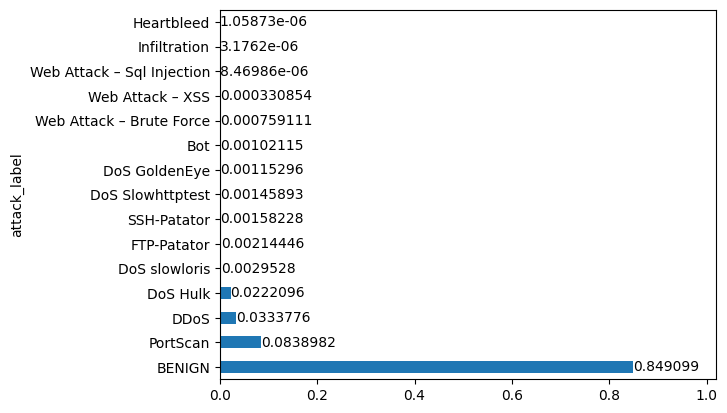

In [97]:
ax = (y.value_counts()/y.size).plot.barh()
ax.margins(x=0.2)
for container in ax.containers:
    ax.bar_label(container)

Jako że nie interesuje nas klasa przy uczeniu, a tylko czy jest to pakiet normalny czy złośliwy, przerabiamy klasy na 0 dla normalnego, i 1 dla ataku.

In [98]:
y.loc[y == "BENIGN"] = 0
y.loc[y != 0] = 1
y = y.astype(int)

C:\Users\Jakub\AppData\Local\Temp\ipykernel_4184\4215623757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y == "BENIGN"] = 0
C:\Users\Jakub\AppData\Local\Temp\ipykernel_4184\4215623757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[y != 0] = 1


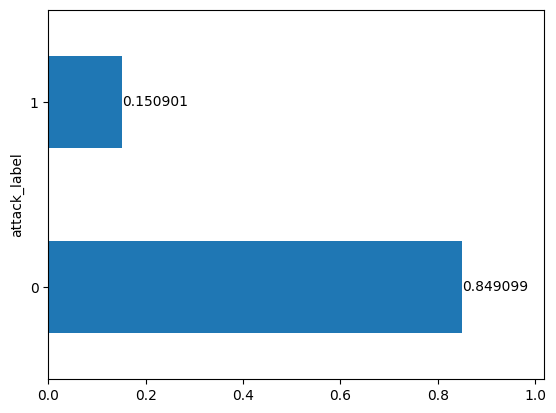

In [99]:
ax = (y.value_counts()/y.size).plot.barh()
ax.margins(x=0.2)
for container in ax.containers:
    ax.bar_label(container)

Sprawdźmy też brakujące wartości 

<Axes: >

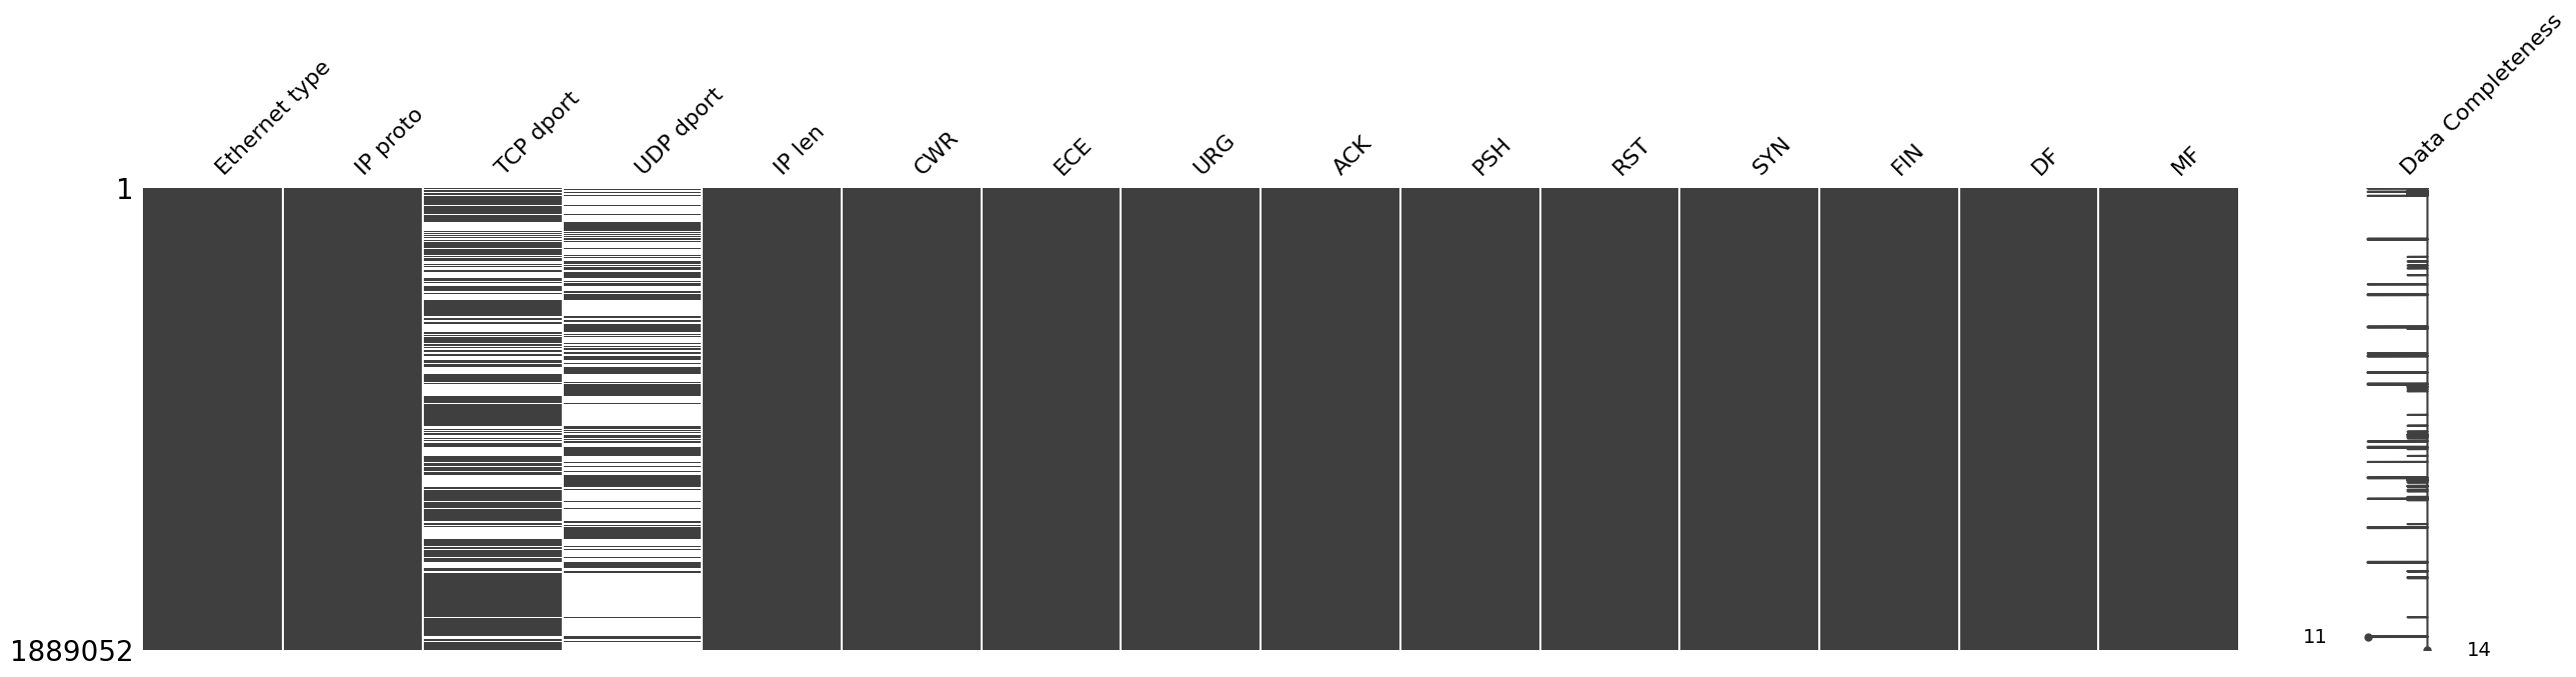

In [100]:
msno.matrix(X, labels=True, figsize=(30, 6))

Aby nie było pustych wartości, w je miejsca wpisujemy 0.

In [101]:
X['TCP dport'] = X['TCP dport'].fillna(0)
X['UDP dport'] = X['UDP dport'].fillna(0)

<Axes: >

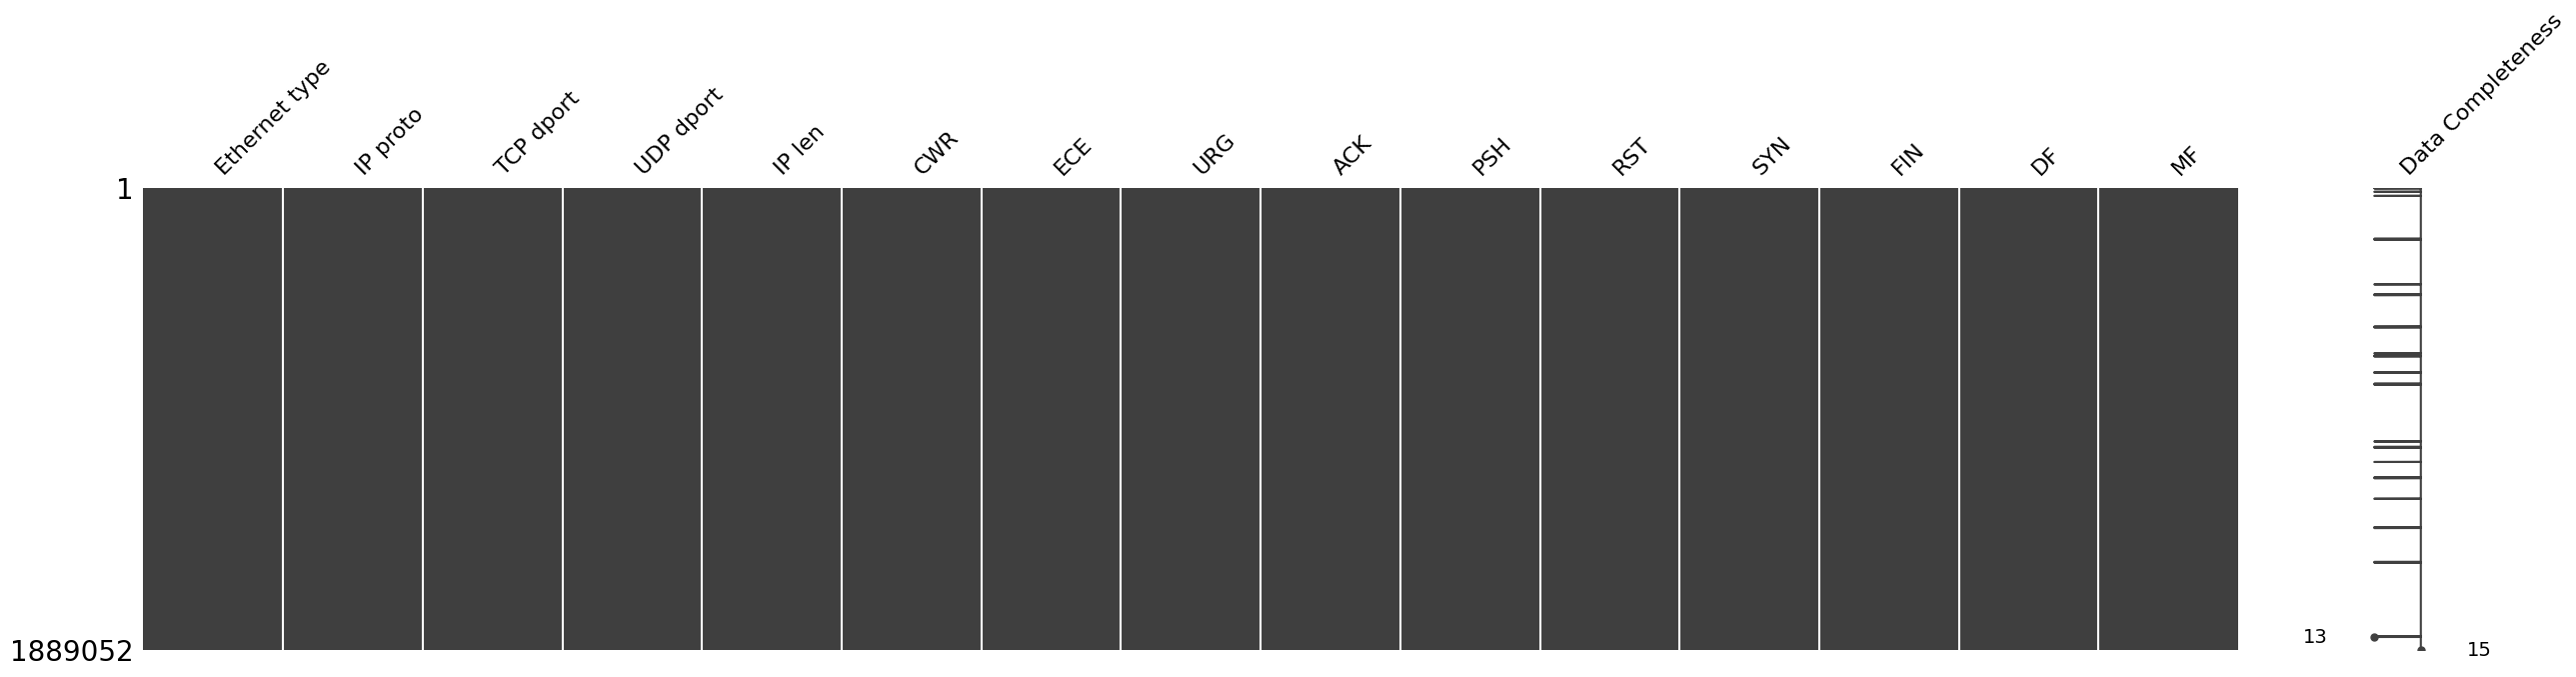

In [102]:
msno.matrix(X, labels=True, figsize=(30, 6))

Dane gotowe, można przejść do trenowania modelu

# 2. Wytrenowanie drzewa decyzyjnego do wykrywania złośliwych pakietów

Dzielimy dane na zbiór treningowy i testowy

In [103]:
features = X.columns

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, shuffle=True, stratify=y
)


Oraz trenujemy drzewo

In [141]:
clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=0)
clf.fit(X_train, y_train)
print(f"AUROC: {roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]):.4f}")

y_pred = clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek:\n", cm)

AUROC: 0.9270
Macierz pomyłek:
 [[315495   5304]
 [ 28890  28122]]


Nasze drzewo jest gotowe. Wykonujemy jego wizualizację

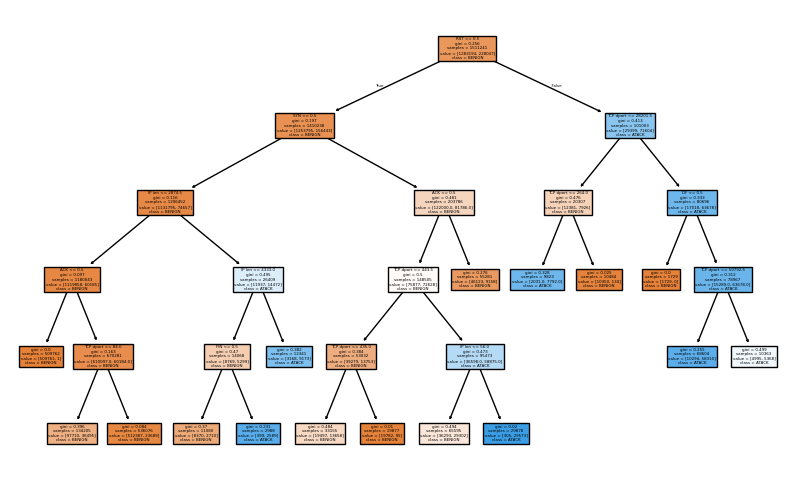

In [142]:
plt.figure(figsize=(10, 6))
plot_tree(clf, filled=True, feature_names=list(X.columns), class_names=["BENIGN", "ATACK"])

plt.savefig('decision_tree.png', dpi=1000, bbox_inches='tight')

Drzewo jest w rzeczywistości serią instrukcji if elese. Dzięki temu można je łatwo przenieść do P4.

In [122]:
from sklearn.tree import _tree

def generate_p4_ifelse(tree, feature_names, field_map):
    """
    Generate P4 if-else code from a trained DecisionTreeClassifier.
    Sets meta.class_label = 1 for drop, meta.class_label = 0 for forward.
    
    Args:
        tree: trained DecisionTreeClassifier
        feature_names: list of feature names (as in your training data)
        field_map: dict mapping feature names to P4 header fields (e.g., {'feature1': 'hdr.ipv4.srcAddr'})
    """
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    def recurse(node, depth):
        indent = "    " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            p4_field = field_map.get(name, name)
            threshold = tree_.threshold[node]
            try:
                threshold_val = int(threshold)
            except:
                threshold_val = threshold
            s = f"{indent}if ({p4_field} <= {threshold_val}) {{\n"
            s += recurse(tree_.children_left[node], depth + 1)
            s += f"{indent}}} else {{\n"
            s += recurse(tree_.children_right[node], depth + 1)
            s += f"{indent}}}\n"
            return s
        else:
            class_idx = tree_.value[node].argmax()
            action = f"meta.class_label = {1 if class_idx == 1 else 0};"
            return f"{indent}{action}\n"

    return recurse(0, 1)

# Assuming X_train is a DataFrame
feature_names = X_train.columns.tolist()
field_map = {
    "Ethernet type":      "hdr.ethernet.etherType",
    "IP proto":           "hdr.ipv4.protocol",
    "TCP dport":          "hdr.tcp.dstPort",
    "UDP dport":          "hdr.udp.dstPort",
    "IP len":             "hdr.ipv4.totalLen",
    "attack_label":       "meta.class_label",
    "CWR":                "hdr.tcp.cwr",
    "ECE":                "hdr.tcp.ece",
    "URG":                "hdr.tcp.urg",
    "ACK":                "hdr.tcp.ack",
    "PSH":                "hdr.tcp.psh",
    "RST":                "hdr.tcp.rst",
    "SYN":                "hdr.tcp.syn",
    "FIN":                "hdr.tcp.fin",
    "DF":                 "hdr.ipv4.flag_df",
    "MF":                 "hdr.ipv4.flag_mf"
}
print(generate_p4_ifelse(clf, feature_names, field_map))



    if (hdr.tcp.rst <= 0) {
        if (hdr.tcp.syn <= 0) {
            if (hdr.ipv4.totalLen <= 2874) {
                if (hdr.tcp.ack <= 0) {
                    meta.class_label = 0;
                } else {
                    if (hdr.tcp.dstPort <= 84) {
                        if (hdr.tcp.fin <= 0) {
                            if (hdr.ipv4.totalLen <= 455) {
                                if (hdr.ipv4.totalLen <= 58) {
                                    if (hdr.ipv4.totalLen <= 40) {
                                        meta.class_label = 0;
                                    } else {
                                        if (hdr.ipv4.totalLen <= 51) {
                                            meta.class_label = 0;
                                        } else {
                                            meta.class_label = 0;
                                        }
                                    }
                                } else {
                     

# 3. Konfiguracja switcha p4

Do implementacji i testowania urzyjemy maszyny wirtualnej P4 Tutorial. Uruchamiamy ją w Virtualbox. <br>
login: P4, hasło P4. <br>

Następnie przechodzimy do katalogu /home/p4/tutorials/exercises/m4 gdzie znajdują się pliki potrzebne do wykonania ćwieczenia. 

##### 3.0 Co chcemy osiągnąć
Wygenerowane wcześniej drzewo decyzyjne zapiszemy jako sekwencje operacji if else. Po dojściu do liścia drzewa zapiszemy w meta.class_label klase pakietu. Dzięki temu, będziemy mogli odrzucić pakiety z klasą złośliwą

##### 3.1 Struktura katalogu z ćwiczeniem 
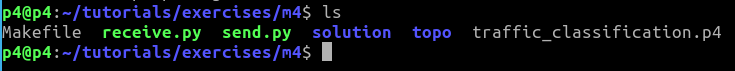
<ul>
<li>topo : folder z topologią</li>
    - topology.json : zawiera informacje o hostach, switchach wraz z połączeniami mięzy nimi i ich konfiguracją <br>
    - s1-runtime.json : plik konfiguracyjny dla przełącznika P4. 
<li>traffic_classification.p4 : plik na którym będziemy działać</li>
<li>send.py i receive.py : urzywane przez hosty do wysyłania kopmunikatów</li>
<li>Makefile : służy do tworzenia (<b>make run</b>) i czyszczenia środowiska (<b>make clean</b>)</li>
</ul>

##### 3.2 definicja nagłówków
W kodzie mamy zdefiniowane 4 nagłówki
- Ethernet (ethernet_t)
- IPv4 (ipv4_t)
- TCP (tcp_t)
- UDP (udp_t)

<br>
Jednym z kryteriów w naszym drzewie decyzyjnym są flagi IPv4 i TCP. W tym momencie nagłówki definiują je jako jedno pole. Jako że o tym czy dana flaga jest dołączona czy jej nie ma świadczy wartość bitu  na danej pozycji w rejestrze flagowym, możemy rozbić je na jednobitowe pola, każde wskazujące bezpośrednio na flage. Ułatwi to późniejsze przepisywanie warunków drzewa<br>

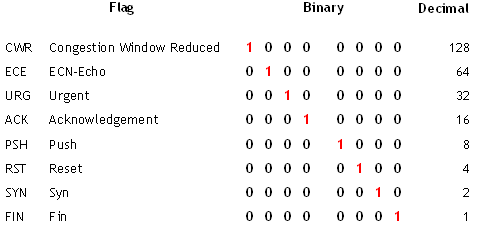


In [11]:
# header ipv4_t {
#     bit<4>    version;
#     bit<4>    ihl;
#     bit<8>    diffserv;
#     bit<16>   totalLen;
#     bit<16>   identification;
#     bit<1>    flag_reserved;
#     bit<1>    flag_df;
#     bit<1>    flag_mf;
#     bit<13>   fragOffset;
#     bit<8>    ttl;
#     bit<8>    protocol;
#     bit<16>   hdrChecksum;
#     ip4Addr_t srcAddr;
#     ip4Addr_t dstAddr;
# }

# header tcp_t {
#     bit<16> srcPort;
#     bit<16> dstPort;
#     bit<32> seqNo;
#     bit<32> ackNo;
#     bit<4>  dataOffset;
#     bit<4>  res;
#     bit<1>  cwr;
#     bit<1>  ece;
#     bit<1>  urg;
#     bit<1>  ack;
#     bit<1>  psh;
#     bit<1>  rst;
#     bit<1>  syn;
#     bit<1>  fin;
#     bit<16> window;
#     bit<16> checksum;
#     bit<16> urgentPtr;
# }

##### 3.3 Drzewo decyzyjne
Znajdź akcję classify_packet. Tutaj zaimplementować należy drzewo decyzyjne. <br> <br>
Każda z wartości nagłówków danego pakietu dostępna jest przy użyciu hdr.udp.X , hdr.tcp.X , hdr.ipv4.X gdzie X jest zdefiniowanym wcześniej polem danego nagłówka. <br> <br>
Popatrz na wygenerowane wcześniej drzewo, i przepisz je do switcha używając instrukcji if else <br> <br>
Aby przypisać klase do pakietu użyj meta.class_label <br> <br>
Popatrz na kod funkcji apply. Jaka wartość class_label odpowiada pakietowi szkodliwemu a jaka normalnemu ? (szkodliwe będziemy odrzucać)

# 4. Test rozwiązania

Zacznijmy od zestawienia środowiska
- Make run
    - kompiluje program i wchodzi do środowiska Mininet
- h1 ping h2
    - sprawdzamy połączenie między hostami
- Ctrl-C, make stop, make clean - wyłącza mininet i usuwa konfiguracje

Aby przetestować rozwiązanie potrzebujemy włączyć konsole naszych 2 hostów <br>
- xterm h1 h2 


Na h2 włączamy program receive.py, a nasępnie na h1 włączamy send.py
- python3 receive.py
- python3 send.py good

Powtarzamy dla złych pakietów <br>
send.py przesyła po 100 pakietów, dzięki temu możemy obliczyć procent odrzuconych złośliwych pakietów, i odrzuconych normalnych pakietów

Odpowiedz na pytania:
- Ile pakietów ze 100 normalnych zostało odebranych ?
- Ile pakietów ze 100 złośliwych zostało odebranych ?
- Czy jakość naszego rozwiązania jest na tyle dobra, aby można było o prawdziwej sieci dropować pakiety zakfalifikowane jako złoźliwe ?